In [177]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import rtree
import pickle

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Event Listing

In [239]:
event_list_df = pd.read_csv("data/NYC_Parks_Events_Listing___Event_Listing.csv", parse_dates=True)

In [240]:
event_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68689 entries, 0 to 68688
Data columns (total 15 columns):
event_id                68689 non-null int64
title                   68689 non-null object
date                    68689 non-null object
start_time              68689 non-null object
end_time                68689 non-null object
location_description    13059 non-null object
description             68685 non-null object
snippet                 68385 non-null object
phone                   53482 non-null object
email                   47694 non-null object
cost_free               68689 non-null int64
cost_description        13807 non-null object
must_see                68689 non-null int64
url                     68687 non-null object
notice                  68689 non-null int64
dtypes: int64(4), object(11)
memory usage: 7.9+ MB


In [243]:
event_list_df.isnull().sum()

event_id                    0
title                       0
date                        0
start_time                  0
end_time                    0
location_description    55630
description                 4
snippet                   304
phone                   15207
email                   20995
cost_free                   0
cost_description        54882
must_see                    0
url                         2
notice                      0
dtype: int64

In [244]:
event_list_df.shape

(68689, 15)

In [248]:
event_list_df.groupby('date').count().shape

(2306, 14)

In [70]:
event_list_df['start_time'] = pd.to_datetime(event_list_df['start_time'], format='%H:%M')

In [71]:
event_list_df[event_list_df.end_time == '24:00']

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice
11088,79666,New Year's Eve Fireworks in Prospect Park,12/31/2013,1900-01-01 23:00:00,24:00,NaN,<p>\n\tStart the celebrations off around 11 p....,Start the celebrations off around 11 p.m. with...,NaN,NaN,1,NaN,1,new-years-eve-fireworks1,0
23359,102431,New Year's Eve Fireworks,12/31/2014,1900-01-01 23:00:00,24:00,NaN,<p>Kick off the New Year&#39;s with this belov...,Kick off the New Year's with this beloved Broo...,NaN,NaN,1,NaN,1,new-years-eve-fireworks,0


In [72]:
event_list_df = event_list_df.drop(event_list_df.index[23359])
event_list_df = event_list_df.drop(event_list_df.index[11088])

In [73]:
event_list_df[event_list_df.end_time == '24:00']

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice


In [74]:
event_list_df['end_time'] = pd.to_datetime(event_list_df['end_time'], format='%H:%M')

In [75]:
event_list_df['date'] = pd.to_datetime(event_list_df.date)

In [76]:
event_list_df['is_event'] = 1

In [77]:
# event_list_df.end_time[40]

In [78]:
# event_list_df.start_time[40]

In [79]:
event_list_df['event_duration'] = ((event_list_df.end_time-event_list_df.start_time).dt.total_seconds())/60

In [80]:
# str(event_list_df.start_time.dt.time[0]).split(":")[0]

In [88]:
event_list_df['DOW'] = event_list_df.date.dt.weekday_name

In [82]:
event_list_df['TOD'] = event_list_df.start_time.dt.hour

In [83]:
event_list_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,is_event,event_duration,DOW,TOD
0,62223,Bird Walks at The New York Botanical Garden,2013-01-05,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,1,60.0,Saturday,11
1,62224,Bird Walks at The New York Botanical Garden,2013-01-12,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,1,60.0,Saturday,11
2,62225,Bird Walks at The New York Botanical Garden,2013-01-19,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,1,60.0,Saturday,11
3,62226,Bird Walks at The New York Botanical Garden,2013-01-26,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,1,60.0,Saturday,11
4,62227,Bird Walks at The New York Botanical Garden,2013-02-02,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,1,60.0,Saturday,11


In [ ]:
# for index, event in event_list_df.iterrows():
#     start = int(str(event_list_df.start_time.dt.time[index]).split(":")[0])
#     end = int(str(event_list_df.end_time.dt.time[index]).split(":")[0])
    
#     if(((start >= 3) & (start < 13)) | ((end >= 3) & (end < 13))):
#         event_list_df.loc[[index],'morning'] = 1
#     else:
#         event_list_df.loc[[index],'morning'] = 0
        
#     if(((start >= 13) & (start < 18)) | ((end >= 13) & (end < 18))):
#         event_list_df.loc[[index],'afternoon'] = 1
#     else:
#         event_list_df.loc[[index],'afternoon'] = 0
        
#     if(((start >= 18) & (start < 3)) | ((end >= 18) & (end < 3))):
#         event_list_df.loc[[index],'night'] = 1
#     else:
#         event_list_df.loc[[index],'night'] = 0

In [20]:
f = open('storage/event_list_df.pckl', 'wb')
pickle.dump(event_list_df, f)
f.close()

In [25]:
f = open('storage/event_list_df.pckl', 'rb')
event_list_df = pickle.load(f)
f.close()

In [85]:
agg_df = event_list_df[event_list_df.date.dt.year == 2017]

In [86]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11954 entries, 26877 to 62585
Data columns (total 19 columns):
event_id                11954 non-null int64
title                   11954 non-null object
date                    11954 non-null datetime64[ns]
start_time              11954 non-null datetime64[ns]
end_time                11954 non-null datetime64[ns]
location_description    2371 non-null object
description             11954 non-null object
snippet                 11950 non-null object
phone                   8685 non-null object
email                   8086 non-null object
cost_free               11954 non-null int64
cost_description        1951 non-null object
must_see                11954 non-null int64
url                     11952 non-null object
notice                  11954 non-null int64
is_event                11954 non-null int64
event_duration          11954 non-null float64
DOW                     11954 non-null object
TOD                     11954 non-null int6

In [249]:
agg_df.shape

(11954, 19)

In [264]:
for i in agg_df.title.unique():
    print(i)
    break

Conference House Art Expo 2017


In [267]:
agg_df.groupby('title')['event_duration'].mean().reset_index().head()

,title,event_duration
0,"""Behind-the-Ropes"" Insider’s Tour of the Merch...",120.0
1,"""Call & Response"" Artist Talk: Jeff Slomba",60.0
2,"""Call & Response"" Dance Performance: Jarrod Be...",60.0
3,"""Call & Response"" Printing Demo: An Artist's R...",180.0
4,'A Taste For Chocolate' Exhibition Opening,120.0


In [255]:
for i in agg_df.columns:
    print(i, " : ", agg_df.groupby(i).count().shape[0])


event_id  :  11954
title  :  3556
date  :  365
start_time  :  56
end_time  :  76
location_description  :  759
description  :  4522
snippet  :  3957
phone  :  597
email  :  595
cost_free  :  2
cost_description  :  329
must_see  :  2
url  :  3485
notice  :  2
is_event  :  1
event_duration  :  58
DOW  :  7
TOD  :  20


In [26]:
agg_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,is_event,event_duration,DOW,TOD
26877,107941,Conference House Art Expo 2017,2017-05-20,1900-01-01 11:00:00,1900-01-01 17:00:00,NaN,<p>Come view original artworks and tree instal...,Come view original artworks and tree installat...,(718) 984-6046,admin@conferencehouse.org,1,NaN,0,resiliency-and-elements,0,1,360.0,5,11
27651,108867,Thursday Evening Hours at the Merchant’s House...,2017-01-05,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,3,12
27652,108868,Thursday Evening Hours at the Merchant’s House...,2017-01-12,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,3,12
27653,108869,Thursday Evening Hours at the Merchant’s House...,2017-01-19,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,3,12
27654,108870,Thursday Evening Hours at the Merchant’s House...,2017-01-26,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,3,12


In [ ]:
plt.hist(agg_df.event_duration, bins=50);

In [ ]:
plt.plot(agg_df.event_id);

## Event Location

In [89]:
loc_df = pd.read_csv('data/NYC_Parks_Events_Listing___Event_Locations.csv')

In [90]:
loc_df.head()

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
1,62224,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
2,62225,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
3,62226,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
4,62227,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"


In [91]:
loc_df.shape

(87092, 10)

In [92]:
loc_df[loc_df.event_id == 141581]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
65098,141581,Gracie Mansion,M081,40.776001,-73.9431,"88th Street & East End Avenue, Carl Schurz Park",10007.0,M,NaN,"(40.77600097656250000, -73.94309997558594000)"


In [93]:
loc_df[loc_df.event_id == 62223]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"


https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8

In [94]:
df = gpd.read_file('data/taxizones/taxi_zones.shp').to_crs({'init': 'epsg:4326'})
df = df.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
gpd.sjoin(gpd.GeoDataFrame(crs={'init': 'epsg:4326'},
    geometry=[Point(-73.9431, 40.776001)]), 
    df, how='left', op='within')

,geometry,index_right,zone,LocationID,borough
0,POINT (-73.9431 40.776001),261,Yorkville East,262,Manhattan


In [95]:
def assign_taxi_zones(df, lon_var, lat_var, locid_var):
    """Joins DataFrame with Taxi Zones shapefile.
    This function takes longitude values provided by `lon_var`, and latitude
    values provided by `lat_var` in DataFrame `df`, and performs a spatial join
    with the NYC taxi_zones shapefile. 
    The shapefile is hard coded in, as this function makes a hard assumption of
    latitude and longitude coordinates. It also assumes latitude=0 and 
    longitude=0 is not a datapoint that can exist in your dataset. Which is 
    reasonable for a dataset of New York, but bad for a global dataset.
    Only rows where `df.lon_var`, `df.lat_var` are reasonably near New York,
    and `df.locid_var` is set to np.nan are updated. 
    Parameters
    ----------
    df : pandas.DataFrame or dask.DataFrame
        DataFrame containing latitudes, longitudes, and location_id columns.
    lon_var : string
        Name of column in `df` containing longitude values. Invalid values 
        should be np.nan.
    lat_var : string
        Name of column in `df` containing latitude values. Invalid values 
        should be np.nan
    locid_var : string
        Name of series to return. 
    """

    import geopandas
    from shapely.geometry import Point


    # make a copy since we will modify lats and lons
    localdf = df[[lon_var, lat_var]].copy()
    
    # missing lat lon info is indicated by nan. Fill with zero
    # which is outside New York shapefile. 
    localdf[lon_var] = localdf[lon_var].fillna(value=0.)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.)
    

    shape_df = geopandas.read_file('data/taxizones/taxi_zones.shp')
    shape_df.drop(['OBJECTID', "Shape_Area", "Shape_Leng", "borough", "zone"],
                  axis=1, inplace=True)
    shape_df = shape_df.to_crs({'init': 'epsg:4326'})

    try:
        local_gdf = geopandas.GeoDataFrame(
            localdf, crs={'init': 'epsg:4326'},
            geometry=[Point(xy) for xy in
                      zip(localdf[lon_var], localdf[lat_var])])

        local_gdf = geopandas.sjoin(
            local_gdf, shape_df, how='left', op='within')
#         return local_gdf
        return local_gdf.LocationID.rename(locid_var)
    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
    return series

In [96]:
loc_df['taxi_zone'] = assign_taxi_zones(loc_df, 'long', 'lat', 'taxi_zones')

In [97]:
loc_df[loc_df.taxi_zone == np.inf]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone


In [98]:
loc_df['taxi_zone'] = loc_df.taxi_zone.fillna(0).astype(int)

In [99]:
loc_df.head()

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
1,62224,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
2,62225,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
3,62226,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
4,62227,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31


## Taxi Trip Data

In [42]:
import random

filename = "data/2017_Green_Taxi_Trip_Data.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 10000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
taxi_df = pd.read_csv(filename, skiprows=skip)

In [43]:
# taxi_df = pd.read_csv('2017_Green_Taxi_Trip_Data.csv', nrows=10000)

In [44]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
VendorID                 10000 non-null int64
lpep_pickup_datetime     10000 non-null object
lpep_dropoff_datetime    10000 non-null object
store_and_fwd_flag       10000 non-null object
RatecodeID               10000 non-null int64
PULocationID             10000 non-null int64
DOLocationID             10000 non-null int64
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
payment_type             10000 non-null int64
trip_type                10000 non-null int64
d

In [45]:
taxi_df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,01/01/2017 12:42:11 AM,01/01/2017 01:08:31 AM,N,1,33,225,1,8.58,27.5,0.5,0.5,0.00,0.0,NaN,0.3,28.80,2,1
1,2,01/01/2017 12:51:07 AM,01/01/2017 12:56:19 AM,N,1,82,223,2,1.75,7.5,0.5,0.5,0.00,0.0,NaN,0.3,8.80,2,1
2,2,01/01/2017 12:07:54 AM,01/01/2017 12:20:18 AM,N,1,223,173,5,3.35,12.5,0.5,0.5,0.00,0.0,NaN,0.3,13.80,2,1
3,2,01/01/2017 12:53:54 AM,01/01/2017 01:04:41 AM,N,1,159,247,1,1.76,9.0,0.5,0.5,0.00,0.0,NaN,0.3,10.30,2,1
4,2,01/01/2017 12:33:55 AM,01/01/2017 12:38:09 AM,N,1,255,255,5,0.47,4.5,0.5,0.5,1.16,0.0,NaN,0.3,6.96,1,1


In [46]:
taxi_df['lpep_pickup_datetime'] = pd.to_datetime(taxi_df.lpep_pickup_datetime)

In [47]:
taxi_df['lpep_dropoff_datetime'] = pd.to_datetime(taxi_df.lpep_dropoff_datetime)

In [48]:
taxi_df['date'] = taxi_df.lpep_pickup_datetime.dt.date

In [49]:
taxi_df['taxi_duration'] = ((taxi_df.lpep_dropoff_datetime - taxi_df.lpep_pickup_datetime).dt.total_seconds())//60

In [56]:
taxi_df = taxi_df.rename(columns={'PULocationID' : 'taxi_zone'})

In [58]:
taxi_df['taxi_zone'] = taxi_df.taxi_zone.fillna(0).astype(int)

In [137]:
# taxi_df['DOW'] = taxi_df.lpep_pickup_datetime.dt.dayofweek.map({0: 'Sunday', 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday"})
taxi_df['DOW'] = taxi_df.lpep_pickup_datetime.dt.weekday_name

In [52]:
taxi_df['TOD']= taxi_df.lpep_pickup_datetime.dt.hour

In [53]:
data = taxi_df.groupby(['DOW', 'TOD', 'PULocationID'])['VendorID'].count().reset_index()

In [54]:
data = data.rename(columns={'VendorID' : 'pickups'})

In [55]:
data.head()

,DOW,TOD,PULocationID,pickups
0,Friday,0,7,2
1,Friday,0,17,1
2,Friday,0,25,1
3,Friday,0,37,1
4,Friday,0,41,6


In [63]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
VendorID                 10000 non-null int64
lpep_pickup_datetime     10000 non-null datetime64[ns]
lpep_dropoff_datetime    10000 non-null datetime64[ns]
store_and_fwd_flag       10000 non-null object
RatecodeID               10000 non-null int64
taxi_zone                10000 non-null int64
DOLocationID             10000 non-null int64
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
payment_type             10000 non-null int64
trip_type                10000 

## Merge Event and Event Locations and Taxi

In [100]:
merged_df = pd.merge(agg_df, loc_df, on=['event_id'])

In [101]:
merged_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,is_event,event_duration,DOW,TOD,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone
0,107941,Conference House Art Expo 2017,2017-05-20,1900-01-01 11:00:00,1900-01-01 17:00:00,NaN,<p>Come view original artworks and tree instal...,Come view original artworks and tree installat...,(718) 984-6046,admin@conferencehouse.org,1,NaN,0,resiliency-and-elements,0,1,360.0,Saturday,11,Conference House Park Visitor Center,R006,40.502602,-74.251801,298 Satterlee Street,NaN,R,1.0,"(40.50260162353500000, -74.25180053710900000)",44
1,108867,Thursday Evening Hours at the Merchant’s House...,2017-01-05,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,Thursday,12,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
2,108868,Thursday Evening Hours at the Merchant’s House...,2017-01-12,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,Thursday,12,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
3,108869,Thursday Evening Hours at the Merchant’s House...,2017-01-19,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,Thursday,12,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
4,108870,Thursday Evening Hours at the Merchant’s House...,2017-01-26,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,1,480.0,Thursday,12,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113


In [102]:
merged_df['date'] = pd.to_datetime(merged_df.date).dt.date

In [103]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12043 entries, 0 to 12042
Data columns (total 29 columns):
event_id                12043 non-null int64
title                   12043 non-null object
date                    12043 non-null object
start_time              12043 non-null datetime64[ns]
end_time                12043 non-null datetime64[ns]
location_description    2392 non-null object
description             12043 non-null object
snippet                 12039 non-null object
phone                   8745 non-null object
email                   8151 non-null object
cost_free               12043 non-null int64
cost_description        1953 non-null object
must_see                12043 non-null int64
url                     12041 non-null object
notice                  12043 non-null int64
is_event                12043 non-null int64
event_duration          12043 non-null float64
DOW                     12043 non-null object
TOD                     12043 non-null int64
name      

In [104]:
data = merged_df.merge(taxi_df, on=['DOW', 'TOD', 'taxi_zone'], how='right')

In [105]:
data.isnull().sum()

event_id                  8890
title                     8890
date_x                    8890
start_time                8890
end_time                  8890
location_description     12218
description               8890
snippet                   8893
phone                    10346
email                    10299
cost_free                 8890
cost_description         12484
must_see                  8890
url                       8891
notice                    8890
is_event                  8890
event_duration            8890
DOW                          0
TOD                          0
name                      8890
park_id                   9522
lat                       8890
long                      8890
address                  11151
zip                      10748
borough                   8932
accessible               10585
Location 1                8890
taxi_zone                    0
VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_an

In [106]:
data.is_event.isnull().sum()

8890

In [107]:
data['is_event'] = data.is_event.fillna(0)

In [108]:
data.is_event.value_counts()

0.0    8890
1.0    4062
Name: is_event, dtype: int64

In [109]:
data.head()

,event_id,title,date_x,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,is_event,event_duration,DOW,TOD,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,date_y,taxi_duration
0,138538.0,Central Park Tour: Northern Forts,2017-04-03,1900-01-01 11:00:00,1900-01-01 12:30:00,NaN,<p>Did you know that the north end of Central ...,See sites that played important strategic role...,(212) 860-1370,tours@centralparknyc.org,0.0,Tickets: $15 per person. Central Park Conserva...,0.0,central-park-tour-northern-forts,0.0,1.0,90.0,Monday,11,Charles A. Dana Discovery Center,M010,40.796799,-73.951500,110th Street between Lenox Avenue and Fifth Av...,10007.0,M,1.0,"(40.79679870605500000, -73.95149993896500000)",43,2,2017-06-12 11:24:45,2017-06-12 11:50:20,N,1,161,1,2.85,17.0,0.0,0.5,2.0,0.0,NaN,0.3,19.8,1,1,2017-06-12,25.0
1,140250.0,Discovery Walks for Families: Balto's Winter W...,2017-01-16,1900-01-01 11:00:00,1900-01-01 12:00:00,NaN,<p>What Central Park Secrets are revealed in t...,What Central Park Secrets are revealed in the ...,212-794-6564,discovery@centralparknyc.org,1.0,NaN,0.0,discovery-walks-for-families-baltos-winter-won...,0.0,1.0,60.0,Monday,11,Outside the Dairy Gift Shop,M010,40.769100,-73.974098,NaN,10007.0,M,NaN,"(40.76910018920898400, -73.97409820556640000)",43,2,2017-06-12 11:24:45,2017-06-12 11:50:20,N,1,161,1,2.85,17.0,0.0,0.5,2.0,0.0,NaN,0.3,19.8,1,1,2017-06-12,25.0
2,140247.0,Central Park Tour: Seneca Village,2017-01-16,1900-01-01 11:00:00,1900-01-01 12:30:00,NaN,<p>Seneca Village was an important community o...,Seneca Village was an important community of p...,(212) 772-0288,tours@centralparknyc.org,0.0,Tickets: $15 per person. Central Park Conserva...,0.0,central-park-tour-seneca-village1,0.0,1.0,90.0,Monday,11,85th Street and Central Park West,M010,40.784599,-73.969704,NaN,10007.0,M,NaN,"(40.78459930419922000, -73.96970367431640000)",43,2,2017-06-12 11:24:45,2017-06-12 11:50:20,N,1,161,1,2.85,17.0,0.0,0.5,2.0,0.0,NaN,0.3,19.8,1,1,2017-06-12,25.0
3,140252.0,Discovery Walks for Families: Balto's Winter W...,2017-02-20,1900-01-01 11:00:00,1900-01-01 12:00:00,NaN,<p>What Central Park Secrets are revealed in t...,What Central Park Secrets are revealed in the ...,212-794-6564,discovery@centralparknyc.org,1.0,NaN,1.0,discovery-walks-for-families-baltos-winter-won...,0.0,1.0,60.0,Monday,11,Outside the Dairy Gift Shop,M010,40.769100,-73.974098,NaN,10007.0,M,NaN,"(40.76910018920898400, -73.97409820556640000)",43,2,2017-06-12 11:24:45,2017-06-12 11:50:20,N,1,161,1,2.85,17.0,0.0,0.5,2.0,0.0,NaN,0.3,19.8,1,1,2017-06-12,25.0
4,141844.0,Central Park Tour: Southern Welcome Tour,2017-03-13,1900-01-01 11:00:00,1900-01-01 12:00:00,NaN,<p>Join Central Park Conservancy guides for an...,"Travel past the Pond and Gapstow Bridge, and o...",(212) 794-6564,tours@centralparknyc.org,1.0,NaN,1.0,central-park-tour-southern-welcome-tour,0.0,1.0,60.0,Monday,11,Inside the Park at Fifth Avenue and 61st Street,M010,40.765499,-73.972198,NaN,NaN,M,NaN,"(40.76549911499023400, -73.97219848632812000)",43,2,2017-06-12 11:24:45,2017-06-12 11:50:20,N,1,161,1,2.85,17.0,0.0,0.5,2.0,0.0,NaN,0.3,19.8,1,1,2017-06-12,25.0


In [ ]:
# data.groupby(['date', 'taxi_zone', 'is_event'])[['trip_distance']].mean()

In [ ]:
# data.groupby(['date', 'taxi_zone']).count()

In [220]:
agg_data = data.groupby(['date_y', 'taxi_zone', 'TOD', 'DOW', 'is_event'])[['VendorID']].count().reset_index()

In [127]:
test = data.groupby(['taxi_zone', 'TOD', 'DOW', 'is_event'])[['trip_distance']].mean().reset_index()

In [131]:
# test.sort_values('trip_distance', ascending=False)

In [221]:
event_t = agg_data[agg_data.is_event == 1.0]

In [222]:
event_f = agg_data[agg_data.is_event == 0.0]

In [223]:
event_t.head()

,date_y,taxi_zone,TOD,DOW,is_event,VendorID
26,2017-01-01,181,15,Sunday,1.0,1
48,2017-01-02,74,18,Monday,1.0,1
53,2017-01-02,190,10,Monday,1.0,1
58,2017-01-03,66,19,Tuesday,1.0,1
80,2017-01-04,74,19,Wednesday,1.0,1


In [ ]:
# map_df = gpd.read_file('data/newyorkzonemap/geo_export_83da3a04-bfe1-4338-bd66-aa8fff31dec0.shp')

In [ ]:
# map_df.plot()

## RandomForest Model

In [158]:
agg_data = agg_data.sort_values('date_y')

In [159]:
agg_data.shape

(9789, 6)

In [170]:
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9789 entries, 0 to 9788
Data columns (total 6 columns):
date_y       9789 non-null object
taxi_zone    9789 non-null int64
TOD          9789 non-null int64
DOW          9789 non-null object
is_event     9789 non-null float64
VendorID     9789 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 535.3+ KB


In [160]:
rows = agg_data.shape[0]

In [161]:
train = agg_data.head(int(rows*0.8))

In [162]:
test = agg_data.tail(int(rows*0.2))

In [164]:
rfrmodel = RandomForestRegressor(n_estimators=20, n_jobs=-1)

In [172]:
reg = rfrmodel.fit(train[['taxi_zone', 'TOD', 'is_event']], train['VendorID'])

In [175]:
training_accuracy = reg.score(train[['taxi_zone', 'TOD', 'is_event']], train['VendorID'])
test_accuracy = reg.score(test[['taxi_zone', 'TOD', 'is_event']], test['VendorID'])
print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy))
print("R^2 on test data:     %0.4f" % (test_accuracy))

############# based on standard predict ################
R^2 on training data: 0.8187
R^2 on test data:     0.5437


In [178]:
rmse = np.sqrt(mean_squared_error(reg.predict(test[['taxi_zone', 'TOD', 'is_event']]), test['VendorID']))
rmse

1.455824107789039

## Graph

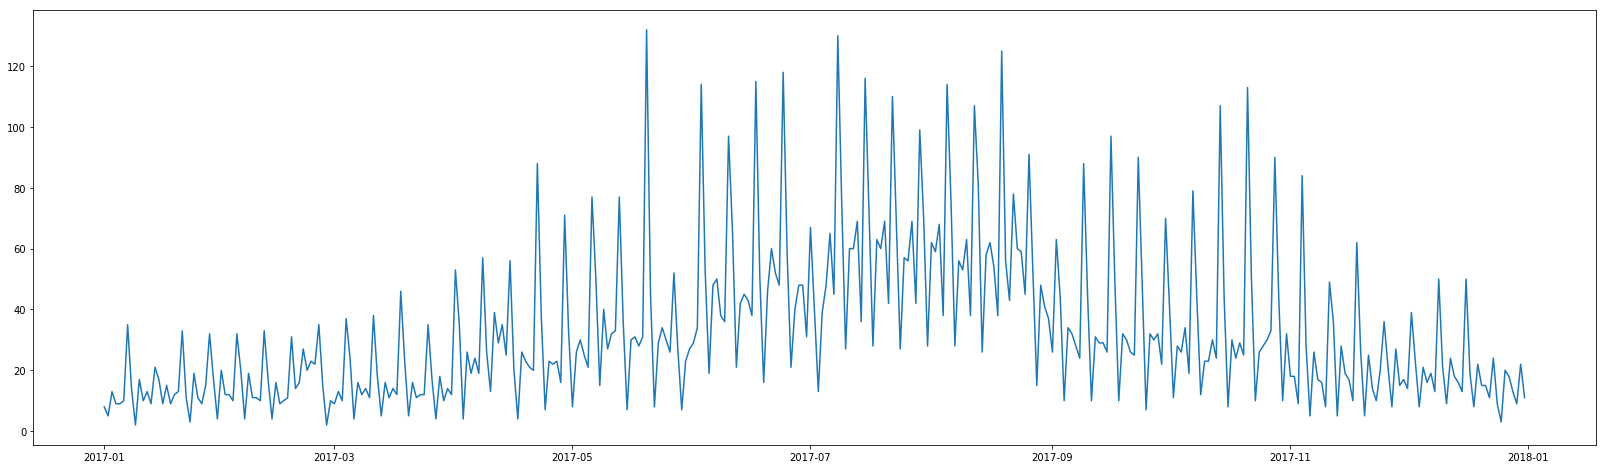

In [209]:
events_graph = merged_df.groupby(['date'])['event_id'].count().reset_index()
plt.figure(figsize=(28,8))
plt.plot(events_graph.date, events_graph.event_id);

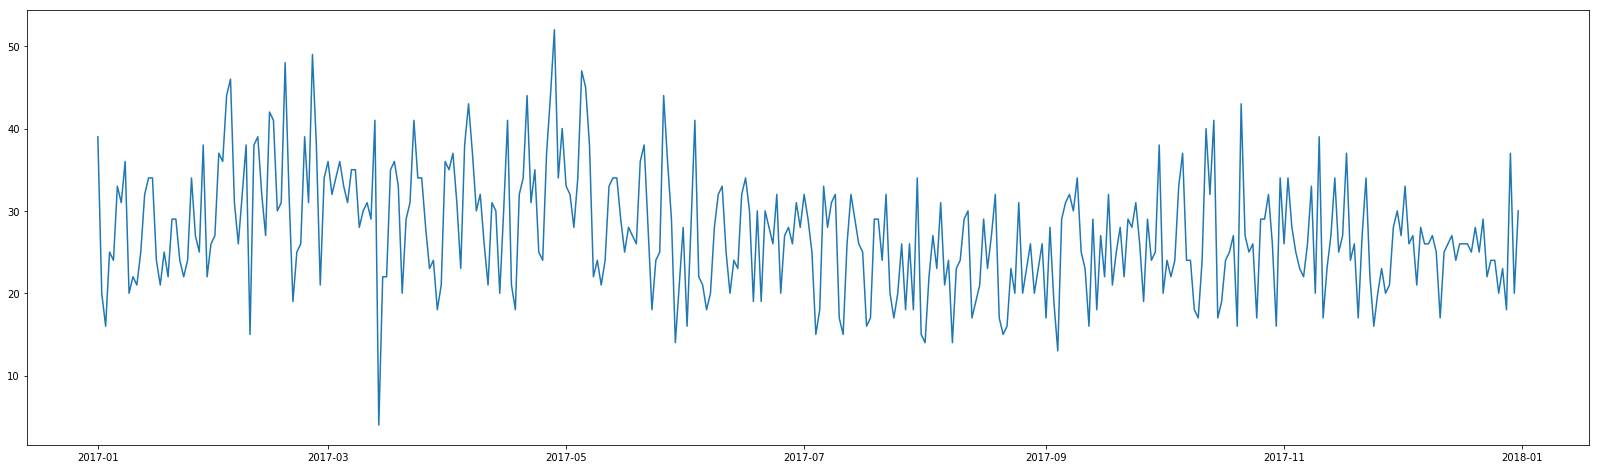

In [211]:
taxi_df_graph = taxi_df.groupby(['date'])['VendorID'].count().reset_index()
plt.figure(figsize=(28,8))
plt.plot(taxi_df_graph.date, taxi_df_graph.VendorID);

In [213]:
import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf

# Define Canvas
x_center = -8234000 
y_center = 4973000

x_half_range = 30000
y_half_range = 25000

NYC = x_range, y_range = ((x_center - x_half_range, x_center + x_half_range), 
                          (y_center-y_half_range, y_center+y_half_range))

plot_width  = 400 
plot_height = int(plot_width/(x_half_range/y_half_range))

cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)

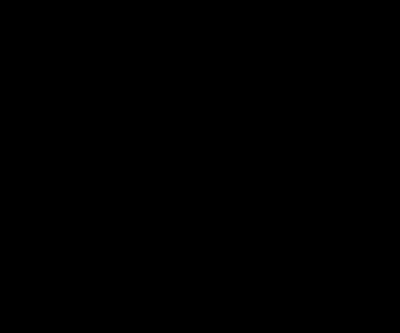

In [218]:
cmapBlue    = ["white", 'darkblue']
dropoff_agg = cvs.points(merged_df, 'long', 'lat') 
dropoff_img = tf.shade(dropoff_agg, cmap=cmapBlue, how='eq_hist')
tf.set_background(dropoff_img, 'black')

In [237]:
event_t.head()

,date_y,taxi_zone,TOD,DOW,is_event,VendorID
26,2017-01-01,181,15,Sunday,1.0,1
48,2017-01-02,74,18,Monday,1.0,1
53,2017-01-02,190,10,Monday,1.0,1
58,2017-01-03,66,19,Tuesday,1.0,1
80,2017-01-04,74,19,Wednesday,1.0,1


In [238]:
taxi_df_graph = event_t.groupby(['date_y','TOD'])['VendorID'].count().reset_index()
plt.figure(figsize=(28,8))
plt.xlabel('time')
plt.ylabel('count')
plt.legend('event')
plt.plot(taxi_df_graph[['date_y','TOD']], taxi_df_graph.VendorID);

# taxi_df_graph = event_f.groupby(['date_y'])['VendorID'].count().reset_index()
# plt.plot(taxi_df_graph.date_y, taxi_df_graph.VendorID);
# plt.legend()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa0524710d0> (for post_execute):


ValueError: view limit minimum -36833.65 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36833.65 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 2016x576 with 1 Axes>